In [1]:
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import acrux_pp

# Проверка правильности навигационных настроек с помощью acrux_pp

В этом файле на примерах показано, как удостовериться в правильности навигационных настроек. 
А также как их, если требуется, уточнить ("откалибровать").

Скачаем лог, если он отсутствует:

In [2]:
LOG_NAME = "pp_tutorial_log.vbp"

In [3]:
if not os.path.exists(LOG_NAME):
    urlretrieve("https://storage.yandexcloud.net/acrux-resources/data/pp_tutorial_log.vbp", 
                filename=LOG_NAME)

Изначально используется режим обработки "forward". 
Файл конфигурации для `acrux_pp.postprocess` имеет вид:

In [4]:
!cat ./pp_config.yaml

log_path: ./pp_tutorial_log.vbp
processing_mode: forward
align_time: true
output_period: 0.1
preload_ephemeris: true
rtcm3_mode: preload
estimate_imu_ant1: only_xy


## Результаты работы с корректными настройками

Корректные настройки для записанного проезда содержатся в самом файле.
Их можно прочитать с помощью `acrux_pp.get_log_info`.

In [5]:
log_info = acrux_pp.get_log_info(LOG_NAME)

In [6]:
log_info.config_commands

['[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500',
 '[0.000000] SET_MOTION_PROFILE CAR',
 '[0.000000] SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050',
 '[0.000000] SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020',
 '[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000']

Напишем небольшую функцию, которая будет записывать команды в файл "commands.txt".

In [7]:
def write_commands(commands):
    with open("./commands.txt", "w") as f:
        for command in commands:
            print(command, file=f)

Запишем корректные настройки и выполним постобработку:

In [8]:
write_commands([
    "SET_MOTION_PROFILE CAR",
    "SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050",
    "SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000",
    "SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500",
    "SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020"
])
result_ref = acrux_pp.postprocess("./pp_config.yaml")

Device serial number is found in log: beta3
Configuration for beta3 is loaded from config database
Applying navigation configuration commands from commands.txt
[0.000000] SET_MOTION_PROFILE CAR
[0.000000] SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050
[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000
[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500
[0.000000] SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020
-----------------------------
-----------------------------
Running main filter processing
[15.8399]: Initialized into no-heading mode
[36.8403]: Translated into standard mode.
[37.8352]: New RTCM 3 base station will be used: id 728, distance 4.0 km
-----------------------------


Теперь перечислим признаки по которым можно судить, что навигационные настройки были корректными (ниже проиллюстрируем).

1. Траектория выглядит правдоподобно и примерно соответствует траектории, построенной по решению ГНСС приемника
2. При использовании базовой станции статус решения в большой доле точек равен RTK_FIXED 
3. Статистика по принятым измерениям проходит критерии по выставленным эмпирическим порогам
4. Дооценки геометрических параметров укладываются в заданные начальные неопределенности

### 1. Траектория

Построим траекторию в NED координатах и высоту для внутреннего решения и ГНСС приемника (поле "gnss_pvt").

In [9]:
lla0 = result_ref.state[['lat', 'lon', 'alt']].iloc[0]

In [10]:
ned = acrux_pp.transform.lla_to_ned(result_ref.state[['lat', 'lon', 'alt']], lla0)
ned_gnss = acrux_pp.transform.lla_to_ned(result_ref.gnss_pvt[['lat', 'lon', 'alt']], lla0)

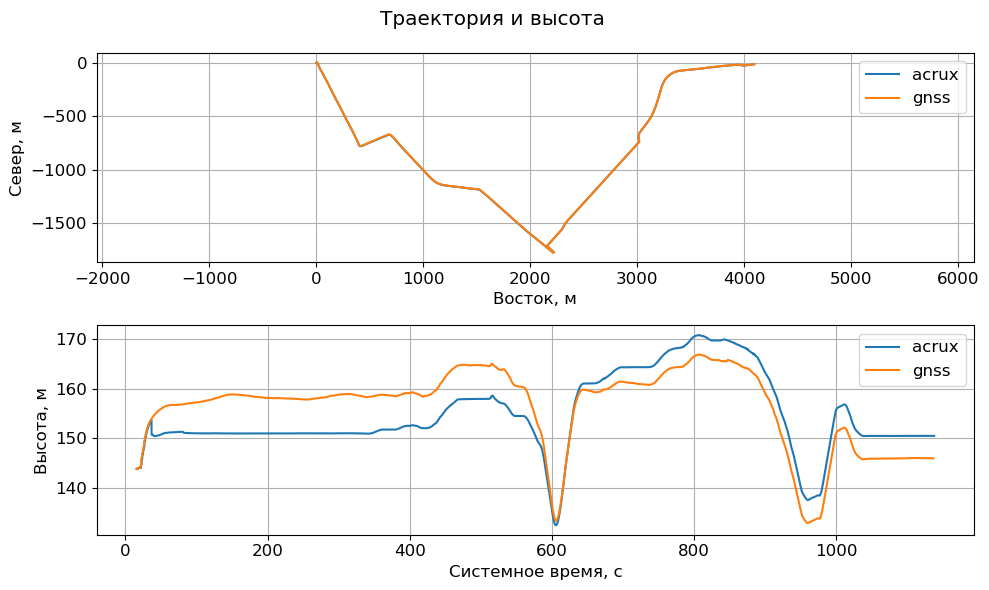

In [11]:
plt.subplot(211)
plt.plot(ned.east, ned.north, label='acrux')
plt.plot(ned_gnss.east, ned_gnss.north, label='gnss')
plt.legend()
plt.xlabel("Восток, м")
plt.ylabel("Север, м")
plt.axis('equal');

plt.subplot(212)
plt.plot(result_ref.state.alt, label='acrux')
plt.plot(result_ref.gnss_pvt.alt, label='gnss')
plt.legend()
plt.xlabel("Системное время, с")
plt.ylabel("Высота, м")
plt.suptitle("Траектория и высота")

plt.tight_layout()

Видим, что траектории качественно совпадают, решение acrux_pp по крайне мере разумное.

### 2. Статус решения

Text(0.5, 1.0, 'Тип решения, 9 = RTK_FIXED')

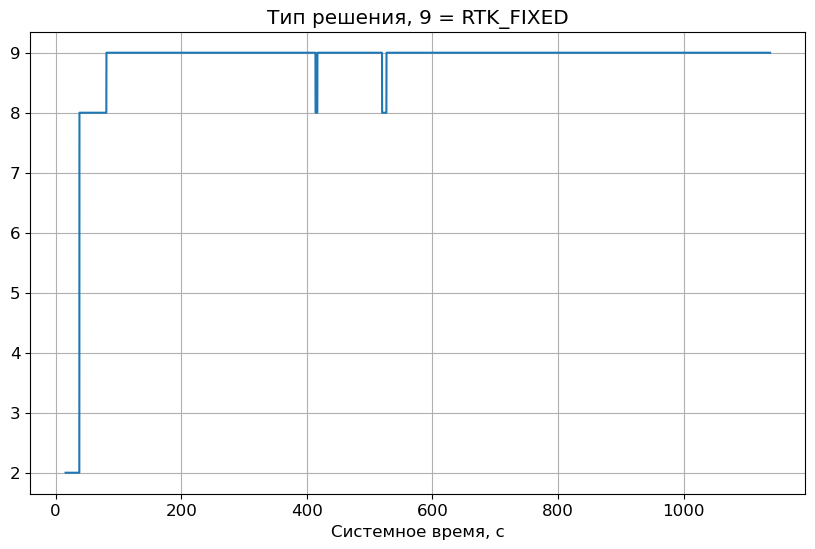

In [12]:
plt.plot(result_ref.state.position_type)
plt.xlabel("Системное время, с")
plt.title("Тип решения, 9 = RTK_FIXED")

В хороших условиях приема и небольшом расстоянии до базовой станции статус обычно должен быть RTK_FIXED.

В данном случае это выполняется. Выведем медианное значение C/N0 и расстояния до базовой станции.

In [13]:
log_info.median_cno

53

In [14]:
result_ref.rtcm3_status.distance.median()

3985.2548375429674

### 3. Статистика принятых измерений

Таблица `stats` содержит статистику по измерениям различных типов.
Измерение считается хорошим ("good"), если процент ("ratio") принятых измерений выше эмпирического порога ("threshold").
Если навигационные настройки корректные, то ожидается, что все измерения будут хорошими.

В данном случае это так:

In [15]:
result_ref.stats

,count,accepted,ratio,threshold,good
kind,,,,,
gnss_pr,46766,43690,0.934226,0.90,True
gnss_prr,57770,56502,0.978051,0.95,True
gnss_cr,45890,45690,0.995642,0.98,True
dual_antenna,577,573,0.993068,0.90,True
dmi,5751,5747,0.999304,0.98,True
motion_model,5778,5778,1.000000,0.98,True
zero_velocity,7950,7950,1.000000,0.98,True
zero_rate,1584,1561,0.985480,0.97,True


### 4. Дооценки геометрических измерений

Изобразим на графиках дооценку вектора IMU-ANT1 (относительно исходных значений), а также оценки СКО.

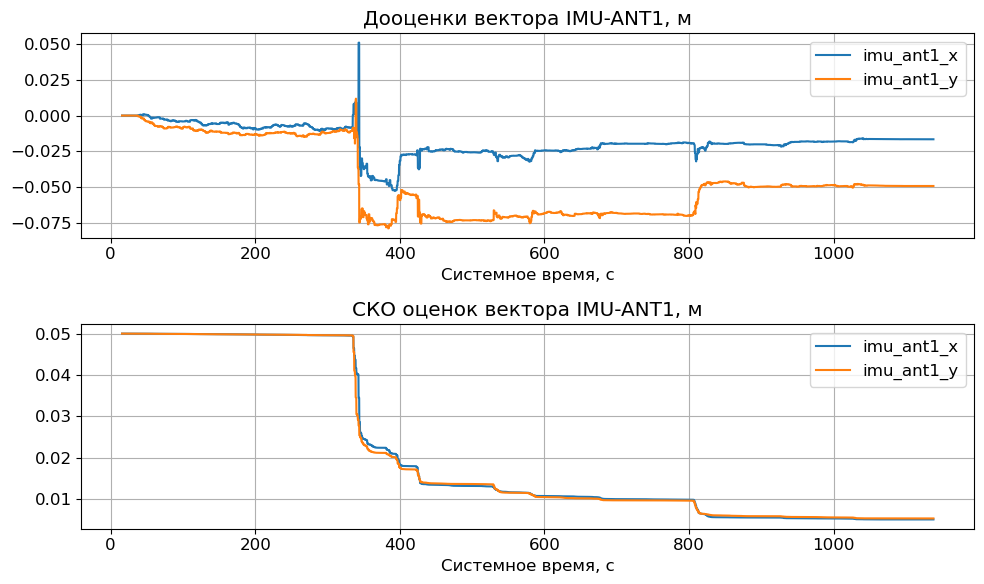

In [16]:
plt.subplot(211)
plt.title("Дооценки вектора IMU-ANT1, м")
plt.plot(result_ref.state.imu_ant1_x - result_ref.state.imu_ant1_x.iloc[0], label='imu_ant1_x')
plt.plot(result_ref.state.imu_ant1_y - result_ref.state.imu_ant1_y.iloc[0], label='imu_ant1_y')
plt.xlabel("Системное время, с")
plt.legend()

plt.subplot(212)
plt.title("СКО оценок вектора IMU-ANT1, м")
plt.plot(result_ref.sd.imu_ant1_x, label='imu_ant1_x')
plt.plot(result_ref.sd.imu_ant1_y, label='imu_ant1_y')
plt.xlabel("Системное время, с")
plt.legend()

plt.tight_layout()

Видно, что дооценка хорошо укладывается в начальное значение СКО равное 5 см.
То есть такие настройки правильные и непротиворечивые.

Изобразим на графиках оценку углов несоосности между автомобилем и ИИБ, а также их СКО.

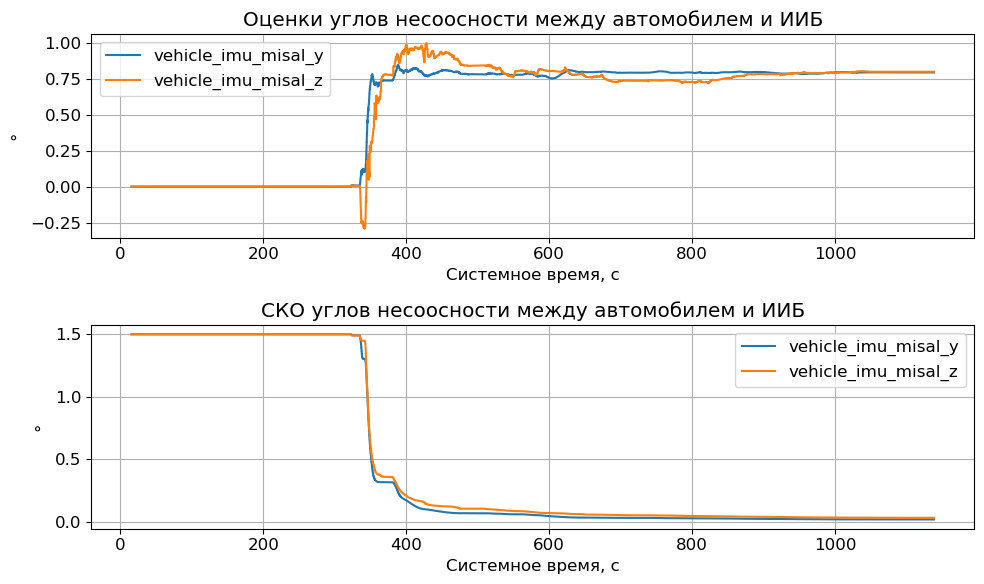

In [17]:
plt.subplot(211)
plt.title("Оценки углов несоосности между автомобилем и ИИБ")
plt.plot(result_ref.state.vehicle_imu_misal_y, label='vehicle_imu_misal_y')
plt.plot(result_ref.state.vehicle_imu_misal_z, label='vehicle_imu_misal_z')
plt.xlabel("Системное время, с")
plt.ylabel("°")
plt.legend()

plt.subplot(212)
plt.title("СКO углов несоосности между автомобилем и ИИБ")
plt.plot(result_ref.sd.vehicle_imu_misal_y, label='vehicle_imu_misal_y')
plt.plot(result_ref.sd.vehicle_imu_misal_z, label='vehicle_imu_misal_z')
plt.xlabel("Системное время, с")
plt.ylabel("°")
plt.legend()

plt.tight_layout()

Здесь также видно, что дооценки углов укладываются в начальное СКО.

## Результаты при неправильных настройках

Далее рассматриваем возможные случаи неправильной настройки.

### Некорретное задание вектора IMU-ANT1

Предположим, что вектор IMU-ANT1 задан существенно неправильно.

In [18]:
write_commands([
    "SET_MOTION_PROFILE CAR",
    "SET_TRANSLATION IMU_ANT1 -0.645 1.000 0.000 0.050 0.050 0.050",
    "SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000",
    "SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500",
    "SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020"
])
result = acrux_pp.postprocess("./pp_config.yaml")

Device serial number is found in log: beta3
Configuration for beta3 is loaded from config database
Applying navigation configuration commands from commands.txt
[0.000000] SET_MOTION_PROFILE CAR
[0.000000] SET_TRANSLATION IMU_ANT1 -0.645 1.000 0.000 0.050 0.050 0.050
[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000
[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500
[0.000000] SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020
-----------------------------
-----------------------------
Running main filter processing
[15.8399]: Initialized into no-heading mode
[36.8403]: Translated into standard mode.
[37.8352]: New RTCM 3 base station will be used: id 728, distance 4.0 km
-----------------------------


В этом случае в целом система будет работоспособной, а решение в общих чертах корректным.
Статистика принятых измерений существенно не ухудшается:

In [19]:
result.stats

,count,accepted,ratio,threshold,good
kind,,,,,
gnss_pr,46766,43689,0.934204,0.90,True
gnss_prr,57770,56425,0.976718,0.95,True
gnss_cr,45890,45620,0.994116,0.98,True
dual_antenna,577,573,0.993068,0.90,True
dmi,5751,5747,0.999304,0.98,True
motion_model,5778,5778,1.000000,0.98,True
zero_velocity,7950,7950,1.000000,0.98,True
zero_rate,1584,1560,0.984848,0.97,True


Алгоритм может дооценивать вектор IMU-ANT1 и в этих условиях, а большое отклонение и является основным индикатором некорректного задания:

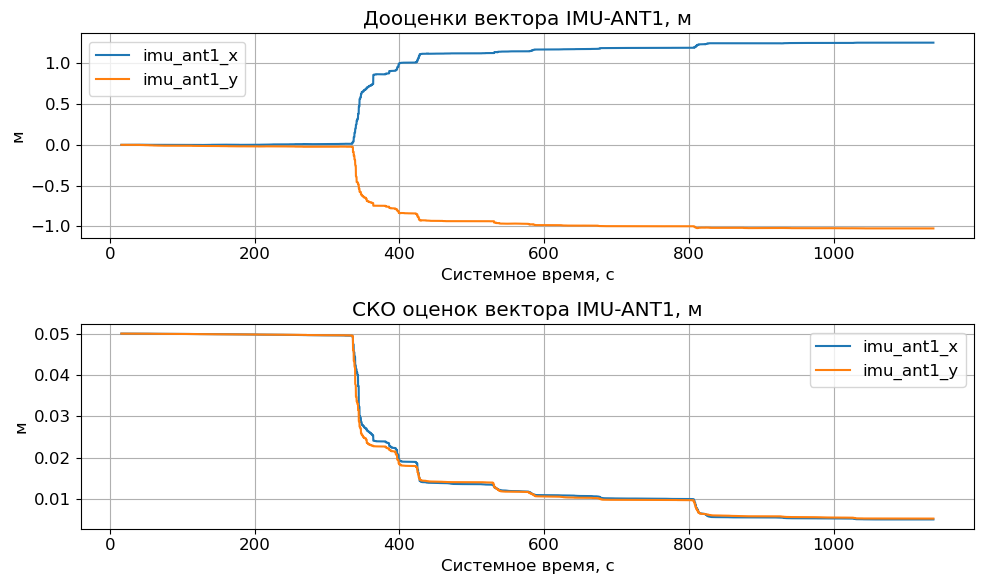

In [20]:
plt.subplot(211)
plt.title("Дооценки вектора IMU-ANT1, м")
plt.plot(result.state.imu_ant1_x - result.state.imu_ant1_x.iloc[0], label='imu_ant1_x')
plt.plot(result.state.imu_ant1_y - result.state.imu_ant1_y.iloc[0], label='imu_ant1_y')
plt.xlabel("Системное время, с")
plt.ylabel("м")
plt.legend()

plt.subplot(212)
plt.title("СКО оценок вектора IMU-ANT1, м")
plt.plot(result.sd.imu_ant1_x, label='imu_ant1_x')
plt.plot(result.sd.imu_ant1_y, label='imu_ant1_y')
plt.xlabel("Системное время, с")
plt.ylabel("м")
plt.legend()

plt.tight_layout()

В случае движения с большим числов поворотов также может ухудшиться процент решения типа RTK_FIXED.
Но в данном случае это не особо проявляется:

Text(0.5, 1.0, 'Тип решения, 9 = RTK_FIXED')

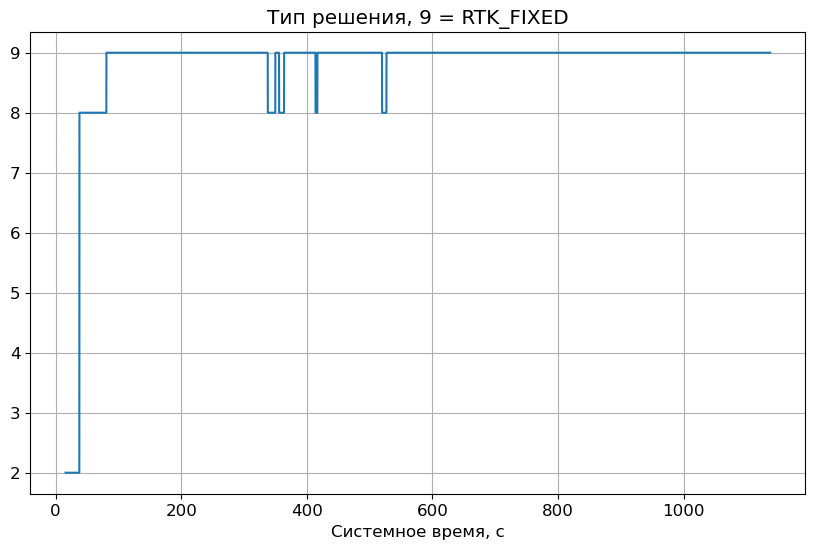

In [21]:
plt.plot(result.state.position_type)
plt.xlabel("Системное время, с")
plt.title("Тип решения, 9 = RTK_FIXED")

### Некорретное задание вектора ANT1-ANT2

Предположим, что вектор ANT1-ANT2 задан с поворотоам на 90 градусов:

In [22]:
write_commands([
    "SET_MOTION_PROFILE CAR",
    "SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050",
    "SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000",
    "SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500",
    "SET_TRANSLATION ANT1_ANT2 0.000 -1.505 0.000 0.020 0.020 0.020"
])

In [23]:
result = acrux_pp.postprocess("./pp_config.yaml")

Device serial number is found in log: beta3
Configuration for beta3 is loaded from config database
Applying navigation configuration commands from commands.txt
[0.000000] SET_MOTION_PROFILE CAR
[0.000000] SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050
[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000
[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500
[0.000000] SET_TRANSLATION ANT1_ANT2 0.000 -1.505 0.000 0.020 0.020 0.020
-----------------------------
-----------------------------
Running main filter processing
[15.8399]: Initialized into no-heading mode
[336.835]: Translated into standard mode.
[337.83]: New RTCM 3 base station will be used: id 728, distance 4.0 km
-----------------------------


Здесь мы видим, что измерения типа "dual_antenna" просто перестали применяться, курс был инициализирован при начале движения, а в остальном все работало правильно:

In [24]:
result.stats

,count,accepted,ratio,threshold,good
kind,,,,,
gnss_pr,36591,35047,0.957804,0.90,True
gnss_prr,44595,43400,0.973203,0.95,True
gnss_cr,35477,35282,0.994503,0.98,True
dual_antenna,562,0,0.000000,0.90,False
dmi,5751,5747,0.999304,0.98,True
motion_model,5778,5778,1.000000,0.98,True
zero_velocity,7950,7950,1.000000,0.98,True
zero_rate,1587,1564,0.985507,0.97,True


Тот же самый результаты был бы при направильной длине вектора.

Однако нужно иметь ввиду, что возможен вариант, когда неправильное задание вектора ANT1-ANT2 приведет к неверному определению начальной ориентации с фатальными последствиями.

# Некорретное задание ориентации VEHICLE-IMU

Предположим ориентация между автомобилием и ИИБ задана ошибочно на 90 градусов по курсовой оси:

In [25]:
write_commands([
    "SET_MOTION_PROFILE CAR",
    "SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050",
    "SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000",
    "SET_ROTATION VEHICLE_IMU 0.000 0.000 90.000 1.500 1.500 1.500",
    "SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020"
])
result = acrux_pp.postprocess("./pp_config.yaml")

Device serial number is found in log: beta3
Configuration for beta3 is loaded from config database
Applying navigation configuration commands from commands.txt
[0.000000] SET_MOTION_PROFILE CAR
[0.000000] SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050
[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000
[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 90.000 1.500 1.500 1.500
[0.000000] SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020
-----------------------------
-----------------------------
Running main filter processing
[15.8399]: Initialized into no-heading mode
[36.8403]: Translated into standard mode.
[37.8352]: New RTCM 3 base station will be used: id 728, distance 4.0 km
-----------------------------


Здесь можно увидеть, что решение попросту "развалилось", т. к. начальная ориентация инерциального блока оказалась изначально существенно неправильной.

Это можно увидеть по статистике и просто по траектории.

In [26]:
result.stats

,count,accepted,ratio,threshold,good
kind,,,,,
gnss_pr,46766,9689,0.207180,0.90,False
gnss_prr,57770,16266,0.281565,0.95,False
gnss_cr,45890,17689,0.385465,0.98,False
dual_antenna,577,223,0.386482,0.90,False
dmi,5751,1858,0.323074,0.98,False
motion_model,5778,1254,0.217030,0.98,False
zero_velocity,7950,4803,0.604151,0.98,False
zero_rate,1584,1559,0.984217,0.97,True


In [27]:
ned = acrux_pp.transform.lla_to_ned(result.state[['lat', 'lon', 'alt']], lla0)
ned_gnss = acrux_pp.transform.lla_to_ned(result.gnss_pvt[['lat', 'lon', 'alt']], lla0)

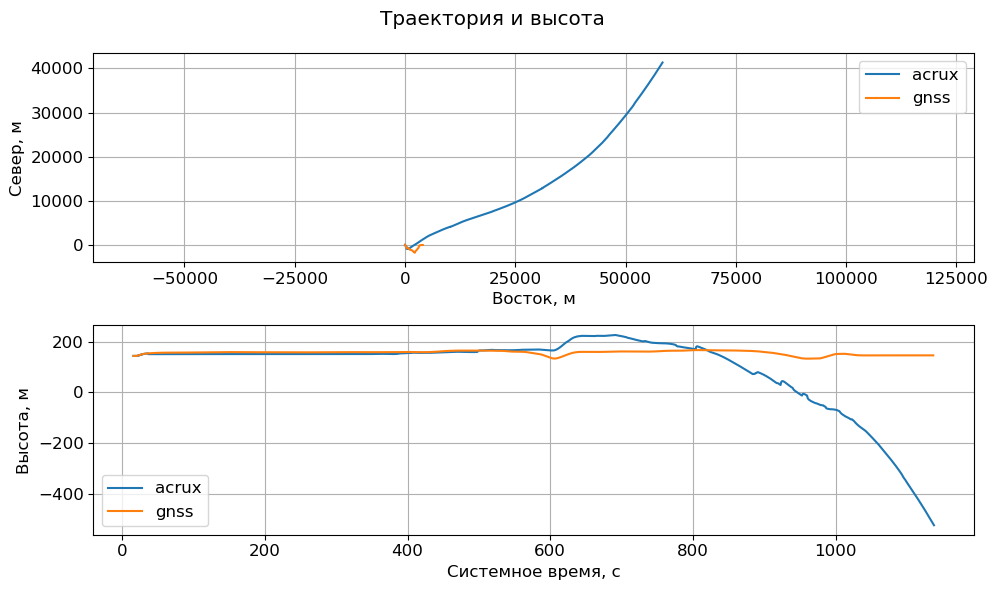

In [28]:
plt.subplot(211)
plt.plot(ned.east, ned.north, label='acrux')
plt.plot(ned_gnss.east, ned_gnss.north, label='gnss')
plt.legend()
plt.xlabel("Восток, м")
plt.ylabel("Север, м")
plt.axis('equal');

plt.subplot(212)
plt.plot(result.state.alt, label='acrux')
plt.plot(result.gnss_pvt.alt, label='gnss')
plt.legend()
plt.xlabel("Системное время, с")
plt.ylabel("Высота, м")
plt.suptitle("Траектория и высота")

plt.tight_layout()

# Некорретное задание ориентации VEHICLE-IMU на 90 градусов, антенный курс не используется

Ситуация будет другой, если антенный курс не будет использоваться.
Для этого уберем строчку "SET_TRANSLATION ANT1_ANT2".

In [29]:
write_commands([
    "SET_MOTION_PROFILE CAR",
    "SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050",
    "SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000",
    "SET_ROTATION VEHICLE_IMU 0.000 0.000 90.000 1.500 1.500 1.500",
])
result = acrux_pp.postprocess("./pp_config.yaml")

Device serial number is found in log: beta3
Configuration for beta3 is loaded from config database
Applying navigation configuration commands from commands.txt
[0.000000] SET_MOTION_PROFILE CAR
[0.000000] SET_TRANSLATION IMU_ANT1 0.645 0.000 0.000 0.050 0.050 0.050
[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000
[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 90.000 1.500 1.500 1.500
-----------------------------
-----------------------------
Running main filter processing
[15.8399]: Initialized into no-heading mode
[336.835]: Translated into standard mode.
[337.83]: New RTCM 3 base station will be used: id 728, distance 4.0 km
-----------------------------


Здесь можно увидеть, что курс инициализируется позже (при начале движения), при этом курс ИИБ оказывается правильным (что наиболее важно), но не ориентация осей автомобиля.
Это приводит к тому, что система в целом работоспособна, но измерения скорости ("dmi") и модели движения ("motion_model") оказываются некорректными.
Это можно увидеть в таблице `stats`:

In [30]:
result.stats

,count,accepted,ratio,threshold,good
kind,,,,,
gnss_pr,36591,35045,0.957749,0.90,True
gnss_prr,44595,43393,0.973046,0.95,True
gnss_cr,35477,35280,0.994447,0.98,True
dual_antenna,0,0,NaN,0.90,True
dmi,5751,2801,0.487046,0.98,False
motion_model,5778,2953,0.511076,0.98,False
zero_velocity,7950,7950,1.000000,0.98,True
zero_rate,1587,1564,0.985507,0.97,True


Кроме этого курс выдавемый курс автомобиля также окажется естественно повернутым на 90 градусов.

Text(0.5, 0, 'Системное время, с')

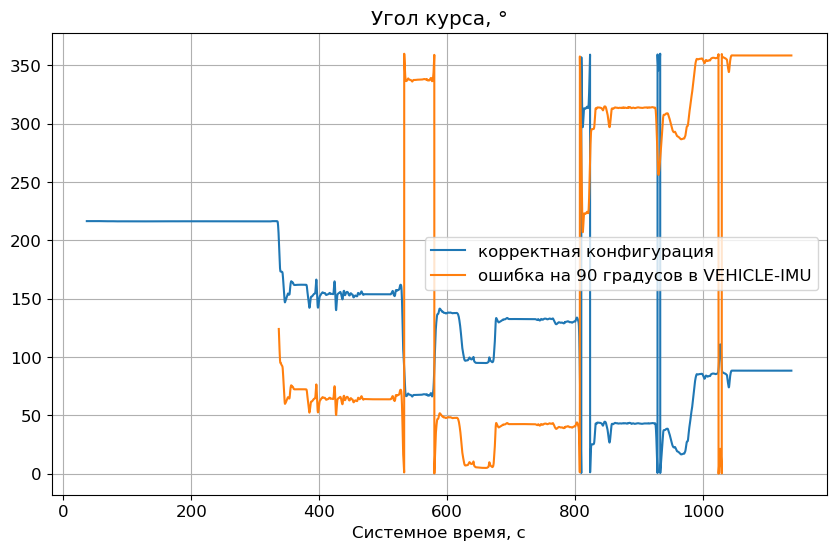

In [31]:
plt.plot(result_ref.state.query("filter_status >= 4").heading, label='корректная конфигурация')
plt.plot(result.state.query("filter_status >= 4").heading, label='ошибка на 90 градусов в VEHICLE-IMU')
plt.legend()
plt.title("Угол курса, °")
plt.xlabel("Системное время, с")

# Уточнение параметров и общие рекомендации

Для получения точных настроек рекомендуется придерживаться следующего алгоритма:

1. В режиме "forward" или "backward_forward" удостовериться, что введенные настройки приблизительно корректные согласно признакам, изложенным выше
2. Если настройки неверные, то исправить ошибки
3. Запустить обработку в режиме "optimization", чтобы получить наиболее достоверные уточненные параметры

Для данного лога запустим обработку в режиме оптимизации:

In [32]:
write_commands([
    "SET_MOTION_PROFILE CAR",
    "SET_TRANSLATION IMU_ANT1 -0.645 1.000 0.000 0.050 0.050 0.050",
    "SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000",
    "SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500",
    "SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020"
])
result_opt = acrux_pp.postprocess("./pp_config_opt.yaml")

Device serial number is found in log: beta3
Configuration for beta3 is loaded from config database
Applying navigation configuration commands from commands.txt
[0.000000] SET_MOTION_PROFILE CAR
[0.000000] SET_TRANSLATION IMU_ANT1 -0.645 1.000 0.000 0.050 0.050 0.050
[0.000000] SET_TRANSLATION IMU_DMI 0.000 -0.300 0.000 0.000 0.000 0.000
[0.000000] SET_ROTATION VEHICLE_IMU 0.000 0.000 0.000 1.500 1.500 1.500
[0.000000] SET_TRANSLATION ANT1_ANT2 -1.505 0.000 0.000 0.020 0.020 0.020
-----------------------------
-----------------------------
Running backward initialization
[1136.82]: Initialized into no-heading mode
[1135.82]: New RTCM 3 base station will be used: id 728, distance 3.1 km
[1135.82]: Translated into standard mode.
-----------------------------
Running main filter processing
[0.00056]: Translated into standard mode.
[22.8355]: New RTCM 3 base station will be used: id 728, distance 4.0 km
-----------------------------
Running optimization
21922 states are to be optimized
    

Уточненная конфигурация находится в поле "updated_config_commands":

In [33]:
result_opt.updated_config_commands

['SET_ROTATION VEHICLE_IMU 0.008 0.791 0.791 1.500 0.020 0.033',
 'SET_TRANSLATION IMU_ANT1 0.617 -0.031 0.000 0.005 0.005 -1.000',
 'SET_TRANSLATION ANT1_ANT2 -1.505 0.027 0.003 0.020 0.002 0.001',
 'DMI_CONFIG 1.011 0.000']

Значения СКО стоит увеличить до более робастных и реалистичных значений. 
Также обратите внимание, что для Z компоненты ANT1_ANT2 фигурирует формальное значение -1, т. к. этот параметр не фигурировал в алгоритме из-за опции `estimate_imut_ant1: only_xy`. Компоненту Z лучше измерять вручную, т. к. она имеет плохую наблюдаемость при движении автомобиля.

Например в этом случае можно рекомендовать следующие настройки:

In [34]:
['SET_ROTATION VEHICLE_IMU 0.008 0.791 0.791 1.500 0.2 0.2',
 'SET_TRANSLATION IMU_ANT1 0.617 -0.031 0.000 0.01 0.01 0.05',
 'SET_TRANSLATION ANT1_ANT2 -1.505 0.027 0.003 0.020 0.01 0.01',
 'DMI_CONFIG 1.011 0.000']

['SET_ROTATION VEHICLE_IMU 0.008 0.791 0.791 1.500 0.2 0.2',
 'SET_TRANSLATION IMU_ANT1 0.617 -0.031 0.000 0.01 0.01 0.05',
 'SET_TRANSLATION ANT1_ANT2 -1.505 0.027 0.003 0.020 0.01 0.01',
 'DMI_CONFIG 1.011 0.000']